In [3]:
import torch, tqdm
from hrnet import HRNet
from vidio.read import OpenCVReader
import numpy as np
import h5py
import os, sys
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter

def to_numpy(tensor):
    return tensor.detach().cpu().numpy()


def parse_heatmap(heatmap, downsample=4):
    B, C, H, W = heatmap.shape
    flat_heatmap = heatmap.reshape((B, C, -1))
    maxima = torch.argmax(flat_heatmap, dim=-1)
    
    u = maxima % W
    v = torch.div(maxima, W, rounding_mode='floor')
    uv = downsample * torch.stack((u, v), dim=-1)
    
    confidence = torch.gather(flat_heatmap, -1, maxima[..., None])[..., 0]
    confidence = torch.clip(confidence, 0, 1)

    uv = to_numpy(uv).astype(np.int32)
    confidence = to_numpy(confidence).astype(np.float32)
    return uv, confidence

def load_model(weights_path, device='cuda'):
    state_dict = torch.load(weights_path)
    nof_joints = state_dict['final_layer.weight'].shape[0]
    model = HRNet(nof_joints=nof_joints)
    model.load_state_dict(state_dict)
    model = model.eval().to(device)
    return model, nof_joints


def crop_image(image, centroid, crop_size):
    """Crop an image around a centroid.

    Parameters
    ----------
    image: ndarray of shape (height, width, 3)
        Image to crop.

    centroid: tuple of int
        (x,y) coordinates of the centroid.

    crop_size: int or tuple(int,int)
        Size of the crop around the centroid. Either a single int for a square
        crop, or a tuple of ints (w,h) for a rectangular crop.

    Returns
    -------
    image: ndarray of shape (crop_size, crop_size, 3)
        Cropped image.
    """
    if isinstance(crop_size, tuple):
        w, h = crop_size
    else:
        w, h = crop_size, crop_size
    x, y = int(centroid[0]), int(centroid[1])

    x_min = max(0, x - w // 2)
    y_min = max(0, y - h // 2)
    x_max = min(image.shape[1], x + w // 2)
    y_max = min(image.shape[0], y + h // 2)

    cropped = image[y_min:y_max, x_min:x_max]
    padded = np.zeros((h, w, *image.shape[2:]), dtype=image.dtype)
    pad_x = max(w // 2 - x, 0)
    pad_y = max(h // 2 - y, 0)
    padded[
        pad_y : pad_y + cropped.shape[0], pad_x : pad_x + cropped.shape[1]
    ] = cropped
    return padded



In [4]:
vid_path = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01704/20230822_J01704_b/bottom.24562650.avi'

camera = vid_path.split('/')[-1].split('.')[0]
if camera=='bottom': 
    weights_path = 'weights/hrnet_bottom.pth'
elif camera=='top':
    weights_path = 'weights/hrnet_top.pth'
else:
    weights_path = 'weights/hrnet_side.pth'

weights_path = 'weights/hrnet_bottom.pth'
model, nof_joints = load_model(weights_path)
model = model.eval().to('cuda')

save_path = vid_path.replace('.avi','.keypoints.h5')
centroid = median_filter(np.load(vid_path.replace('.avi','.centroid.npy')), (11,1)).astype(int)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32, 32))


In [5]:
reader = OpenCVReader(vid_path)
nframes = len(reader)
with h5py.File(save_path, 'w') as h5f:
    h5f.create_dataset('uv', shape=(nframes, nof_joints, 2))
    h5f.create_dataset('conf', shape=(nframes, nof_joints))
    for i, im in tqdm.tqdm(enumerate(reader), total=nframes):
        with torch.no_grad():
            im = crop_image(im, centroid[i], 512)
            im = clahe.apply(im[:,:,0])
            x = im[None,None].astype(np.float32)/255
            y_pred = model(torch.Tensor(x).to('cuda'))
            uv, conf = parse_heatmap(y_pred, downsample=2)
        uv = uv[0] + centroid[i][None,None]-256
        h5f['uv'][i] = uv
        h5f['conf'][i] = conf[0]
        if i > 1: break


  0%|          | 2/216000 [00:02<60:21:45,  1.01s/it] 


In [6]:
for i, im in tqdm.tqdm(enumerate(reader), total=nframes):
    if i > 1: break

  0%|          | 2/216000 [00:00<36:58, 97.38it/s]


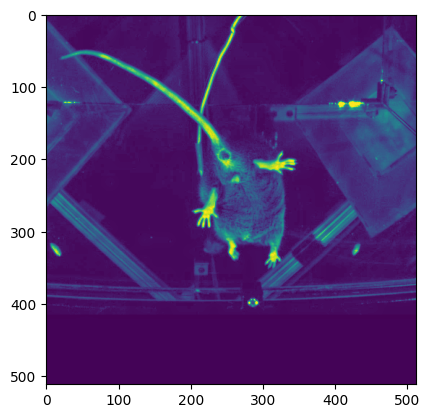

In [8]:
plt.imshow(x[0,0])

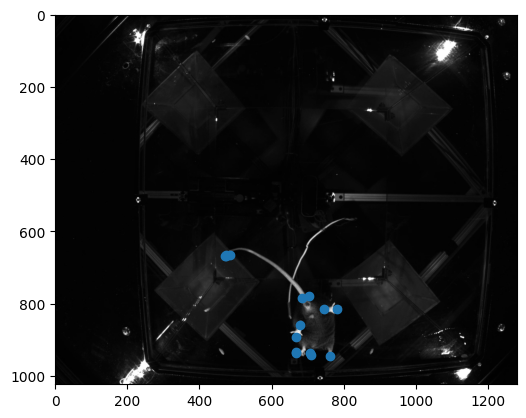

In [9]:
plt.imshow(im)
plt.scatter(*(uv-256).T)

In [2]:
import glob
cmd = 'sbatch -p gpu_quad -t 18:00:00 --mem 3GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_hrnet.py {}"""'

dates = ['20230904','20230903']
videos = []
for d in dates:
    videos += glob.glob(f'/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/*/{d}*/*.mp4')

for ff in videos:
    print(cmd.format(ff))



sbatch -p gpu_quad -t 18:00:00 --mem 3GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_hrnet.py /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230904_J01601/side1.24548223.mp4"""
sbatch -p gpu_quad -t 18:00:00 --mem 3GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_hrnet.py /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230904_J01601/side3.24562655.mp4"""
sbatch -p gpu_quad -t 18:00:00 --mem 3GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_hrnet.py /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01601/20230904_J01601/bottom.24562650.mp4"""
sbatch -p gpu_quad -t 18:00:00 --mem 3GB --gres=gpu:1 -c 2 --wrap  """module load ffmpeg; module load gcc/9.2.0; module load cuda/11.7; python apply_hrnet.py /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/r

In [3]:
frame_ix = 10085

vid_path = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01704/20230829_J01704/bottom.24562650.avi'
reader = OpenCVReader(vid_path)
im = reader[frame_ix]
x = im[:,:,0][None,None].astype(np.float32)/255

In [4]:
model_ix = 155
weights_path = f'hrnet_checkpoints/imagenet_{model_ix}.pth'
model, nof_joints = load_model(weights_path)
model = model.eval().to('cuda')
y_pred = model(torch.Tensor(x).to('cuda'))
uv, conf = parse_heatmap(y_pred, downsample=2)
conf = conf.squeeze()
uv = uv.squeeze()

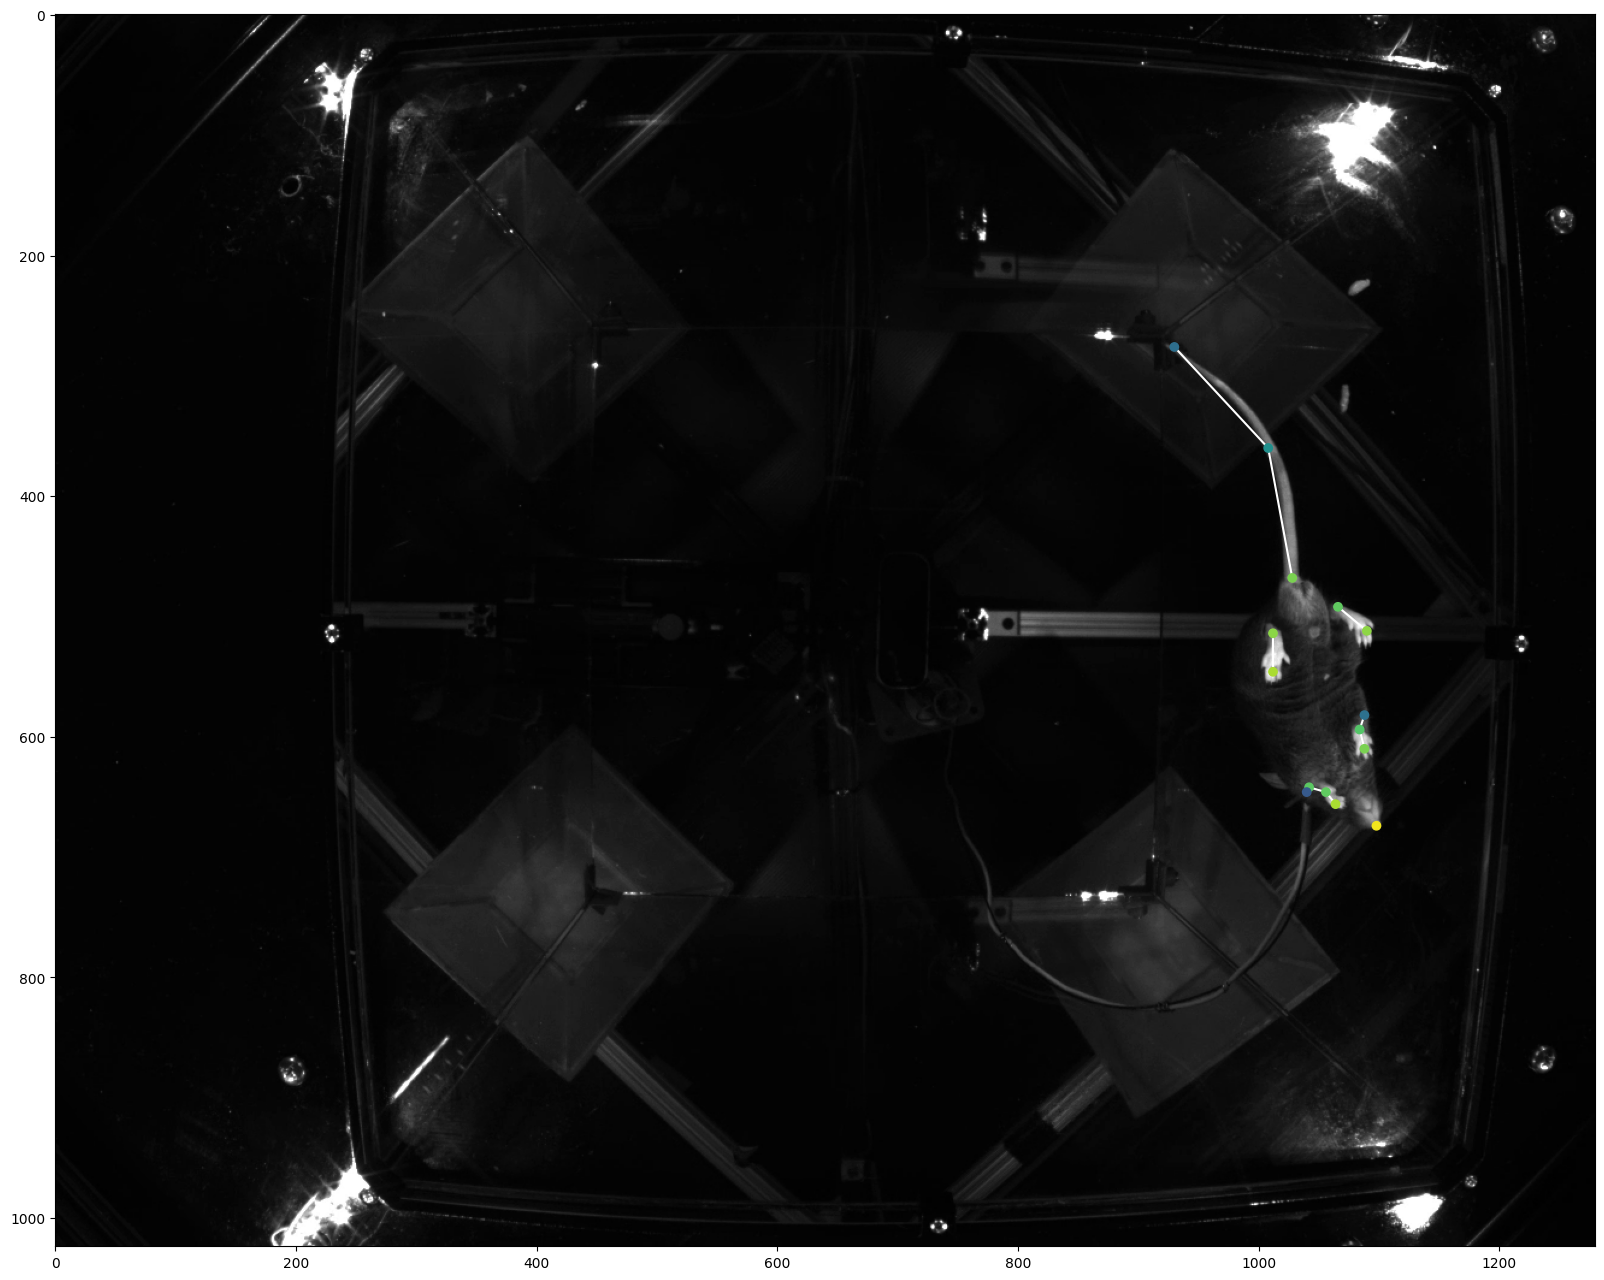

In [5]:
plt.imshow(im)
for i,j in edges:
    if conf[i]>0.2 and conf[j]>0.2:
        plt.plot(*uv[[i,j]].T, c='w', zorder=1)
plt.scatter(*uv[conf>0.2].T, c=conf[conf>0.2], vmin=0, vmax=1, zorder=2)
plt.gcf().set_size_inches((20,16))

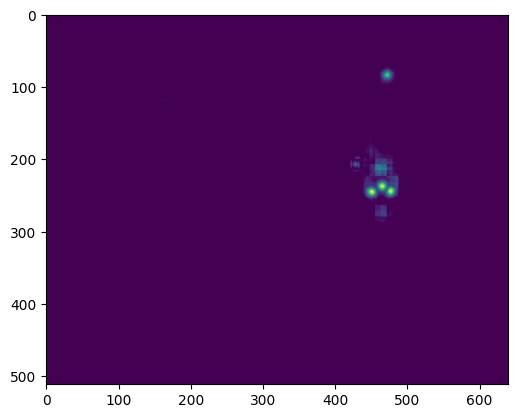

In [34]:
plt.imshow(y_pred.detach().cpu().numpy()[0].max(0))

In [10]:
import torch, tqdm
from hrnet import HRNet
from vidio.read import OpenCVReader
import numpy as np
import h5py
import os, sys

def to_numpy(tensor):
    return tensor.detach().cpu().numpy()


def parse_heatmap(heatmap, downsample=4):
    B, C, H, W = heatmap.shape
    flat_heatmap = heatmap.reshape((B, C, -1))
    maxima = torch.argmax(flat_heatmap, dim=-1)
    
    u = maxima % W
    v = torch.div(maxima, W, rounding_mode='floor')
    uv = downsample * torch.stack((u, v), dim=-1)
    
    confidence = torch.gather(flat_heatmap, -1, maxima[..., None])[..., 0]
    confidence = torch.clip(confidence, 0, 1)

    uv = to_numpy(uv).astype(np.int32)
    confidence = to_numpy(confidence).astype(np.float32)
    return uv, confidence

def load_model(weights_path, device='cuda'):
    state_dict = torch.load(weights_path)
    nof_joints = state_dict['final_layer.weight'].shape[0]
    model = HRNet(nof_joints=nof_joints)
    model.load_state_dict(state_dict)
    model = model.eval().to(device)
    return model, nof_joints



vid_path = '/n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01704/20230829_J01704/bottom.24562650.avi' #sys.argv[1]

model_ix = 155
weights_path = f'hrnet_checkpoints/imagenet_{model_ix}.pth'
model, nof_joints = load_model(weights_path)
model = model.eval().to('cuda')

reader = OpenCVReader(vid_path)
nframes = len(reader)
#save_path = vid_path.replace('.avi','.keypoints.h5')
save_path = 'detections/'+vid_path.split('/')[-1].replace('.avi','.keypoints.h5')

with h5py.File(save_path, 'w') as h5f:
    h5f.create_dataset('uv', shape=(nframes, nof_joints, 2))
    h5f.create_dataset('conf', shape=(nframes, nof_joints))
    for i, im in tqdm.tqdm(enumerate(reader), total=nframes):
        with torch.no_grad():
            x = im[:,:,0][None,None].astype(np.float32)/255
            y_pred = model(torch.Tensor(x).to('cuda'))
            uv, conf = parse_heatmap(y_pred, downsample=2)
            del x, y_pred
            
        h5f['uv'][i] = uv[0]
        h5f['conf'][i] = conf[0]

  0%|          | 77/216000 [00:08<6:39:56,  9.00it/s]


KeyboardInterrupt: 

In [11]:
rm detections/*

In [7]:
! ffprobe /n/groups/datta/Jonah/kpms_reviews_6cam_thermistor/raw_data/J01704/20230829_J01704/top.24562653.avi

ffprobe version 3.3.3-static http://johnvansickle.com/ffmpeg/  Copyright (c) 2007-2017 the FFmpeg developers
  built with gcc 6.4.0 (Debian 6.4.0-2) 20170724
  configuration: --enable-gpl --enable-version3 --enable-static --disable-debug --disable-ffplay --disable-indev=sndio --disable-outdev=sndio --cc=gcc-6 --enable-fontconfig --enable-frei0r --enable-gnutls --enable-gray --enable-libass --enable-libfreetype --enable-libfribidi --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-librtmp --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libvidstab --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxvid --enable-libzimg
  libavutil      55. 58.100 / 55. 58.100
  libavcodec     57. 89.100 / 57. 89.100
  libavformat    57. 71.100 / 57. 71.100
  libavdevice    57.  6.100 / 57.  6.100
  libavfilter     6. 82.100 /  6. 82.100
  libswscale  